In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 27 00:37:30 2022

@author: iqiukp
"""

import numpy as np
import time
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator, OutlierMixin
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.model_selection import train_test_split

class BaseSVDD(BaseEstimator, OutlierMixin):
    """One-Classification using Support Vector Data Description (SVDD).

    Parameters
    ----------
    C : float, default=1.0
        Regularization parameter. The strength of the regularization is
        inversely proportional to C. Must be strictly positive. The penalty
        is a squared l2 penalty.
    kernel : {'linear', 'poly', 'rbf', 'sigmoid'}, default='rbf'
        Specifies the kernel type to be used in the algorithm.
        It must be one of 'linear', 'poly', 'rbf', 'sigmoid'.
    degree : int, default=3
        Degree of the polynomial kernel function ('poly').
        Ignored by all other kernels.
    gamma : {'scale', 'auto'} or float, default='scale'
        Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
        - if ``gamma='scale'`` (default) is passed then it uses
          1 / (n_features * X.var()) as value of gamma,
        - if 'auto', uses 1 / n_features.
    coef0 : float, default=0.0
        Independent term in kernel function.
        It is only significant in 'poly' and 'sigmoid'.

    n_jobs : int, default=None
        The number of parallel jobs to run.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    """

    def __init__(self, 
                 C=0.9,
                 kernel='rbf',
                 degree=3,
                 gamma=None,
                 coef0=1,
                 display='on',
                 n_jobs=None):

        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma       
        self.coef0 = coef0
        self.n_jobs = n_jobs
        self.display = display
        self.X = None
        self.y = None
        self.weight = None
        self.exist_label = True
        self.label_type = None
        self.support_vectors = None
        self.support_vector_indices = None
        self.n_support_vectors = None
        self.n_iterations = None
        self.object_value = None
        self.alpha = None
        self.alpha_tolerance = 1e-6
        self.support_vector_alpha = None
        self.n_support_vectors_ratio = None
        self.radius = None
        self.center = None
        self.offset = None
        self.distance = None
        self.accuracy = None
        self.predicted_y = None
        self.running_time = None
        self.boundary_indices = None
        self.classes_ = None
        

   
    @property 
    def n_samples(self):
        return self.X.shape[0]
    @property 
    def n_features(self):
        return self.X.shape[1]
    @property 
    def n_positive_samples(self):
        return np.sum(self.y == 1)
    @property 
    def n_negative_samples(self):
        return np.sum(self.y == -1)
    
 
    def fit(self, X, y=None, weight=None):
        """Fit the model from data in X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples, 1)
            The target values (class labels in classification, 
            1 for positive samples and -1 for negative samples)
        weight : array-like of shape (n_samples, 1), default=None
            
        Returns
        -------
        self : object
            Returns self.
        """

        start_time = time.time()
        # parameter preprocessing
        self.X, self.y, self.y_type, self.exist_y = self._check_X_y(X, y)

        if self.y_type == 'single':
            self.C = [self.C, 1]
    
        if self.y_type == 'hybrid':
            self.C = [self.C, 2/self.n_negative_samples]
            
        if weight is None:
            self.weight = np.ones((self.n_samples, 1), dtype=np.int64)
        else:
            self.weight = weight   
            
        # check 'gamma'
        if self.gamma == 0:
            raise ValueError(
                "The gamma value of 0.0 is invalid. Use 'auto' to set"
                " gamma to a value of 1 / n_features.") 
        if self.gamma is None:
            self.gamma = 'scale'
        if isinstance(self.gamma, str):
            if self.gamma == "scale":
               X_var = X.var()
               self.gamma = 1.0 / (X.shape[1] * X_var) if X_var != 0 else 1.0
            elif self.gamma == "auto":
                self.gamma = 1.0 / X.shape[1]
            else:
               raise ValueError(
                   "When 'gamma' is a string, it should be either 'scale' or 'auto'.")
  
        # get SVDD model
        self.get_model()
        display_ = self.display
        self.display = 'off'
        self.predicted_y_ = self.predict(self.X, self.y)
        self.accuracy = accuracy_score(self.y, self.predicted_y_)
        self.display = display_
        end_time = time.time()
        self.running_time = end_time - start_time

        # display    
        if self.display == 'on':
           self.display_fit() 
        return self
   
    def get_model(self):
        #
        K = self._get_kernel(self.X, self.X)
        self.solve_problem(K)

    def _get_kernel(self, X, Y=None):
        # get kernel matrix
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {"gamma": self.gamma, "degree": self.degree, "coef0": self.coef0}

        return pairwise_kernels(
            X, Y, metric=self.kernel, filter_params=True, n_jobs=self.n_jobs, **params)

    def solve_problem(self, K):
        """ 
        DESCRIPTION
        
        Solve the Lagrange dual problem using cvxopt
        

        minimize      (1/2)*x'*P*x + q'*x
        subject to    G*x <= h
                      A*x = b                    
        --------------------------------------------------
        
        """ 

        solvers.options['show_progress'] = False
        K = np.multiply(self.y * self.y.T, K)
        
        # P
        n = K.shape[0]
        P = K + K.T
        
        # q
        q = -np.multiply(self.y, np.mat(np.diagonal(K)).T)

        # G
        G1 = -np.eye(n)
        G2 = np.eye(n)
        G = np.append(G1, G2, axis=0)
        
        # h
        h1 = np.zeros([n, 1])
        h2 = np.ones([n, 1])
        
        if self.y_type == 'single':
            h2[self.y == 1] = self.C[0] * self.weight[self.y == 1]
        
        if self.y_type == 'hybrid':
            h2[self.y == 1] = self.C[0] * self.weight[self.y == 1]
            h2[self.y == -1] = self.C[1] * self.weight[self.y == -1]

        h = np.append(h1, h2, axis=0)
        h2_ = h2
        
        # A, b
        A = np.ones([n, 1]).T
        b = np.ones([1, 1])

        # 
        P = matrix(P)
        q = matrix(q)
        G = matrix(G)
        h = matrix(h)
        A = matrix(A)
        b = matrix(b)

        #
        sol = solvers.qp(P, q, G, h, A, b)
        
        self.object_value = np.array(sol['dual objective'])
        self.n_iterations = np.array(sol['iterations'])

        if len(np.array(sol['x'])) == 0:
            warnings.warn("No solution for the SVDD model could be found.\n")
            self.alpha = np.zeros((self.n_samples, 1))
            self.alpha[0][0] = 1
        else:
            self.alpha = np.array(sol['x'])     

        self.alpha = self.y * self.alpha
        self.support_vector_indices = np.where(np.abs(self.alpha) > self.alpha_tolerance)[0][:]
        
        # boundary indices  
        tmp_1 = self.alpha[self.support_vector_indices, 0]
        tmp_2 = h2_[self.support_vector_indices, 0]
        tmp_3 = np.where(tmp_1 < tmp_2)[0][:] 
        tmp_4 = np.where(tmp_1 > self.alpha_tolerance)[0][:] 
        self.boundary_indices = self.support_vector_indices[np.array(list(set(tmp_3) & set(tmp_4)))]

        # support vectors
        self.alpha[np.where(np.abs(self.alpha) < self.alpha_tolerance)[0][:]] = 0
        self.support_vectors = self.X[self.support_vector_indices, :]
        self.support_vector_alpha = self.alpha[self.support_vector_indices]
        self.n_support_vectors = self.support_vector_indices.shape[0]
        self.n_support_vectors_ratio = self.n_support_vectors/self.n_samples

        if self.n_support_vectors_ratio > 0.5:
            warnings.warn("The fitted SVDD model may be overfitting.\n")

        # offset, center, radius
        tmp_5 = np.dot(np.ones((self.n_samples, 1)), self.alpha.T)
        tmp_6 = np.multiply(tmp_5, K)
        tmp_ = -2*np.sum(tmp_6, axis=1, keepdims=True)        
        self.offset = np.sum(np.multiply(np.dot(self.alpha, self.alpha.T), K)) 
        self.center = np.dot(self.alpha.T, self.X)
        self.radius = np.sqrt(np.mean(np.diag(K)) + self.offset+np.mean(tmp_[self.boundary_indices, 0]))

    def predict(self, X, y=None):
        """Predict the class labels for the provided data.

        Parameters
        ----------
        X : array-like of shape (n_queries, n_features)
            Test samples.
        y : (optional) array-like, shape (n_samples, 1)
            The target values (class labels in classification, 
            1 for positive samples and -1 for negative samples)

        Returns
        -------
        predicted_y : array-like, shape (n_samples, 1)
            The predicted target values 
        """

        start_time = time.time()
        results = {}
        results['X'], results['y'], results['y_type'], results['exist_y'] = self._check_X_y(X, y)
        results['n_samples'] = results['X'].shape[0]
        results['distance'] = self.get_distance(X)
        results['predicted_y'] = np.mat(np.ones(results['n_samples'])).T
        index_ = results['distance'] > self.radius
        results['predicted_y'][index_] = -1
        results['n_alarm'] = np.sum(index_==True)  
          
        if results['exist_y'] == True:
            results['accuracy'] = accuracy_score(results['y'], results['predicted_y'])

        end_time = time.time()
        results['running_time'] = end_time - start_time
        # display    
        if self.display == 'on':
            self.display_predict(results)
        return results['predicted_y']
    
    def get_distance(self, X):
        # compute the distance between the samples and the center
        K = self._get_kernel(X, self.X)
        K_ = self._get_kernel(X, X)
        tmp_1 = np.dot(np.ones((X.shape[0], 1), dtype=np.int64), self.alpha.T)
        tmp_2 = np.multiply(tmp_1, K)
        tmp_ = -2*np.sum(tmp_2, axis=1, keepdims=True)  
        distance = np.sqrt(np.mat(np.diag(K_)).T+self.offset+tmp_)
        return distance
    
    def fit_predict(self, X, y=None, weight=None):
        # Perform fit on X and returns labels for X.
        self.fit(X, y, weight)
        return self.predict(X, y)
        
    def decision_function(self, X):
        """Signed distance to the separating hyperplane.
        Signed distance is positive for an inlier and negative for an outlier.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The data matrix.
        Returns
        -------
        dec : ndarray of shape (n_samples, 1)
            Returns the decision function of the samples.
            The anomaly score of the input samples. The lower, 
            the more abnormal. Negative scores represent outliers,
            positive scores represent inliers.
            
        """
        return self.radius-self.get_distance(X)
    
    def get_params(self, deep=True):
        """
        Get parameters for this estimator.
        Parameters
        ----------
        deep : bool, default=True
            If True, will return the parameters for this estimator and
            contained subobjects that are estimators.
        Returns
        -------
        params : dict
            Parameter names mapped to their values.
        """
        out = dict()
        for key in self._get_param_names():
            value = getattr(self, key)
            if deep and hasattr(value, "get_params"):
                deep_items = value.get_params().items()
                out.update((key + "__" + k, val) for k, val in deep_items)
            out[key] = value
        return out 

    def set_params(self, **params):
        """
        Set the parameters of this estimator.
        The method works on simple estimators as well as on nested objects
        (such as :class:`~sklearn.pipeline.Pipeline`). The latter have
        parameters of the form ``<component>__<parameter>`` so that it's
        possible to update each component of a nested object.
        Parameters
        ----------
        **params : dict
            Estimator parameters.
        Returns
        -------
        self : estimator instance
            Estimator instance.
        """
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)

        nested_params = defaultdict(dict)  # grouped by prefix
        for key, value in params.items():
            key, delim, sub_key = key.partition("__")
            if key not in valid_params:
                raise ValueError(
                    "Invalid parameter %s for estimator %s. "
                    "Check the list of available parameters "
                    "with `estimator.get_params().keys()`." % (key, self)
                )

            if delim:
                nested_params[key][sub_key] = value
            else:
                setattr(self, key, value)
                valid_params[key] = value

        for key, sub_params in nested_params.items():
            valid_params[key].set_params(**sub_params)

        return self
 
    def _check_X_y(self, X, y):

        # check for labels
        if y is None:
            y = np.ones((X.shape[0], 1))
            exist_y = False
        else:
            exist_y = True   

        # check for object type (numpy.ndarray)
        if type(X) is not np.ndarray or type(y) is not np.ndarray:
            raise SyntaxError("The type of X and y must be 'numpy.ndarray'.\n")
        
        # check for data dimensionality
        if len(X.shape) != 2 or len(y.shape) != 2:
            raise SyntaxError("The X and y must be 2D.\n")
          
        # check for data length
        if X.shape[0] != y.shape[0]:
            raise SyntaxError("The length of X and y must the same.\n")   
             
        # check for label values
        tmp_ = np.unique(y)
        if np.all(tmp_ == np.array([1])) or np.all(tmp_ == np.array([-1])):
            y_type = 'single'
           
        elif np.all(tmp_ == np.array([1, -1])) or np.all(tmp_ == np.array([-1, 1])):
            y_type = 'hybrid'        
          
        else:
            errorText = "SVDD is only supported for one-class or binary classification. "\
                        "The label must be 1 for positive samples or -1 for negative samples.\n"
            raise SyntaxError(errorText)
            
        self.classes_ = np.unique(y)

        return X, y, y_type, exist_y

    def display_fit(self):
        # display the fitting results       
        print('\n')
        print('*** Fitting of the SVDD model is completed. ***\n')
        print('running time         = %.4f seconds'   % self.running_time)
        print('kernel function      = %s'             % self.kernel)
        print('iterations           = %d'             % self.n_iterations)
        print('number of samples    = %d'             % self.n_samples)
        print('number of features   = %d'             % self.n_features)
        print('number of SVs        = %d'             % self.n_support_vectors)
        print('ratio of SVs         = %.4f %%'        % (100*self.n_support_vectors_ratio))
        print('accuracy             = %.4f %%'        % (100*self.accuracy))
        print('\n')        
        
    def display_predict(self, results):
        # display test results       
        print('\n')
        print('*** Prediction of the provided data is completed. ***\n')
        print('running time         = %.4f seconds'   % results['running_time'])
        print('number of samples    = %d'             % results['n_samples'])                                                        
        print('number of alarm      = %d'             % results['n_alarm'])  
        if results['exist_y'] == True:
            print('accuracy             = %.4f %%'        % (100*results['accuracy']))
        print('\n')  

    def plot_distance(self, radius, distance):
        """ 
        DESCRIPTION
        
        Plot the curve of distance
        --------------------------------------------------------------- 
        
        """ 

        n = distance.shape[0]
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(1, 1, 1)
        radius = np.ones((n, 1))*radius

        ax.plot(radius, 
                color='r',
                linestyle='-', 
                marker='None',
                linewidth=3, 
                markeredgecolor='k',
                markerfacecolor='w', 
                markersize=6)
        
        ax.plot(distance,
                color='k',
                linestyle=':',
                marker='o',
                linewidth=1,
                markeredgecolor='k',
                markerfacecolor='C4',
                markersize=6)
        
        ax.set_xlabel('Samples')
        ax.set_ylabel('Distance')
        
        ax.legend(["Radius", "Distance"], 
                  ncol=1, loc=0, 
                  edgecolor='black', 
                  markerscale=1, fancybox=True)
        ax.yaxis.grid()
        plt.show()

    def plot_boundary(self, X, y=None, expand_ratio=0.2, n_grids=50, 
                      color_map='RdYlBu', n_level=6):
        """ 
        DESCRIPTION
        
        Plot the boundary
        --------------------------------------------------------------- 
        
        """ 
        start_time = time.time()  
        dim = X.shape[1]
        if dim != 2:
            raise SyntaxError('Visualization of decision boundary only supports for 2D data')
        x_range = np.zeros(shape=(n_grids, 2))
        for i in range(2):  
            _tmp_ = (np.max(X[:, i])-np.min(X[:, i]))*expand_ratio
            xlim_1 = np.min(X[:, i])-_tmp_
            xlim_2 = np.max(X[:, i])+_tmp_
            x_range[:, i] = np.linspace(xlim_1, xlim_2, n_grids)
        
        # grid
        xv, yv = np.meshgrid(x_range[:, 0], x_range[:, 1])
        num1 = xv.shape[0]
        num2 = yv.shape[0]
        print('Calculating the grid scores (%04d*%04d)...\n' %(num1, num2))
        distance_ = self.get_distance(np.c_[xv.ravel(), yv.ravel()])
        distance = distance_.reshape(xv.shape)
        end_time = time.time()
        print('Calculation of the grid scores is completed. Time cost %.4f seconds\n' % (end_time-start_time))

        fig = plt.figure(figsize=(20, 6))
        
        # figure 1: the 3D contour
        #ax1 = fig.add_subplot(1, 3, 1, projection='3d') 
        #ax1.plot_surface(xv, yv, distance, cmap=color_map)
        #ax1.contourf(xv, yv, distance.A, n_level, zdir='z', offset=np.min(distance)*0.9, cmap=color_map)
        #ax1.set_zlim(np.min(distance)*0.9, np.max(distance)*1.05)

        # figure 2: the 2D contour
        #ax2 = fig.add_subplot(1, 3, 2)    
        #ctf1 = ax2.contourf(xv, yv, distance, n_level, alpha=0.8, cmap=color_map)
        #ctf2 = ax2.contour(xv, yv, distance, n_level, colors='black', linewidths=1)
        #plt.clabel(ctf2, inline=True)
        #plt.colorbar(ctf1)

        # figure 3: the 2D contour and data
        ax3 = fig.add_subplot(1, 3, 3)
        _, y, _, _ = self._check_X_y(X, y) 
        tmp_1 = y == 1
        tmp_2 = y == -1
        positive_indices = tmp_1[:, 0]
        negative_indices = tmp_2[:, 0]

        if self.y_type == 'single':

            ax3.scatter(X[:, 0], 
                        X[:, 1],
                        facecolor='C0', marker='o', s=100, linewidths=2,
                        edgecolor='black', zorder=2)

            ax3.scatter(X[self.support_vector_indices, 0],
                        X[self.support_vector_indices, 1],
                        facecolor='C2', marker='o', s=144, linewidths=2,
                        edgecolor='black', zorder=2)
        
            ax3.contour(xv, yv, distance, levels=[self.radius],
                        colors='C3', linewidths=7, zorder=1)
            
            ax3.legend(["Data", "Support vectors"], 
                      ncol=1, loc='upper left', edgecolor='black',
                      markerscale=1.2, fancybox=True) 
                
        else:
            ax3.scatter(X[positive_indices, 0], 
                        X[positive_indices, 1],
                        facecolor='C0', marker='o', s=100, linewidths=2,
                        edgecolor='none', zorder=2)
            
            ax3.scatter(X[negative_indices, 0], 
                        X[negative_indices, 1],
                        facecolor='red', marker='x', s =100, linewidths=2,
                        edgecolor='black', zorder=2)
        
            ax3.scatter(X[self.support_vector_indices, 0],
                        X[self.support_vector_indices, 1],
                        facecolor='C2', marker='o', s=144, linewidths=2,
                        edgecolor='none', zorder=2)
            
            ax3.contour(xv, yv, distance, levels=[self.radius],
                        colors='black', linewidths=7, zorder=1)
            
            ax3.legend(["Objetive data", "Outliers", "Support vectors"], 
                      ncol=1, loc='upper left', edgecolor='black',
                      markerscale=1.2, fancybox=True) 
        
        ax3.set_facecolor('none')
        ax3.spines['top'].set_visible(False)
        ax3.spines['right'].set_visible(False)

        plt.grid(linestyle='none')
        plt.show()
    
class BananaDataset():
    """
        Banana-shaped dataset generation and partitioning.
        
    """
    def generate(**kwargs):
        # Banana-shaped dataset generation
        number_p = kwargs['number_p']
        number_n = kwargs['number_n']
        display = kwargs['display']
        
        # parameters for banana-shaped dataset
        sizeBanana = 3
        varBanana = 1.2
        param_1 = 0.02
        param_2 = 0.02
        param_3 = 0.98
        param_4 = -0.8 # x-axsis shift
        # generate 
        class_p = param_1 * np.pi+np.random.rand(number_p, 1) * param_3 * np.pi
        data_p = np.append(sizeBanana * np.sin(class_p), sizeBanana * np.cos(class_p), axis=1)
        data_p = data_p + np.random.rand(number_p, 2) * varBanana
        data_p[:, 0] = data_p[:, 0] - sizeBanana * 0.5
        label_p = np.ones((number_p, 1), dtype=np.int64)
        
        class_n = param_2 * np.pi - np.random.rand(number_n, 1) * param_3 * np.pi
        data_n = np.append(sizeBanana * np.sin(class_n), sizeBanana * np.cos(class_n), axis=1)
        data_n = data_n + np.random.rand(number_n, 2)*varBanana
        data_n = data_n + np.ones((number_n, 1)) * [sizeBanana * param_4, sizeBanana * param_4]
        data_n[:, 0] = data_n[:, 0] + sizeBanana * 0.5
        label_n = -np.ones((number_n, 1), dtype=np.int64)
        
        # banana-shaped dataset
        data = np.append(data_p, data_n, axis=0)
        label = np.append(label_p, label_n, axis=0)
        
        if display == 'on':
            pIndex = label == 1
            nIndex = label == -1
            fig = plt.figure(figsize=(10,6))
            ax = fig.add_subplot(1, 1, 1)
            ax.scatter(data[pIndex[:, 0], 0], data[pIndex[:, 0], 1],
                    facecolor='C0', marker='o', s=100, linewidths=2,
                    edgecolor='none', zorder=2)
            
            ax.scatter(data[nIndex[:, 0], 0], data[nIndex[:, 0], 1],
                    facecolor='C3', marker='x', s = 100, linewidths=2,
                    edgecolor='black', zorder=2)
            
            
            ax.set_xlim([-6, 5])
            ax.set_ylim([-7, 7])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

        
        return data, label
    
    def split(data, label, **kwargs):
        # Banana-shaped dataset partitioning.
        
        ratio = kwargs['ratio']
        X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=ratio,
                                                             random_state=None, shuffle=True, stratify=label)
        pIndex = y_train == 1
        nIndex = y_train == -1
        X_train = np.append(X_train[pIndex[:, 0], :], X_train[nIndex[:, 0], :], axis=0)
        y_train = np.append(y_train[pIndex[:, 0], :], y_train[nIndex[:, 0], :], axis=0)

        pIndex = y_test == 1
        nIndex = y_test == -1
        X_test = np.append(X_test[pIndex[:, 0], :], X_test[nIndex[:, 0], :], axis=0)
        y_test = np.append(y_test[pIndex[:, 0], :], y_test[nIndex[:, 0], :], axis=0)
        
        return X_train, X_test ,y_train, y_test



*** Fitting of the SVDD model is completed. ***

running time         = 0.0091 seconds
kernel function      = rbf
iterations           = 10
number of samples    = 73
number of features   = 2
number of SVs        = 12
ratio of SVs         = 16.4384 %
accuracy             = 93.1507 %


Calculating the grid scores (0050*0050)...

Calculation of the grid scores is completed. Time cost 0.1905 seconds



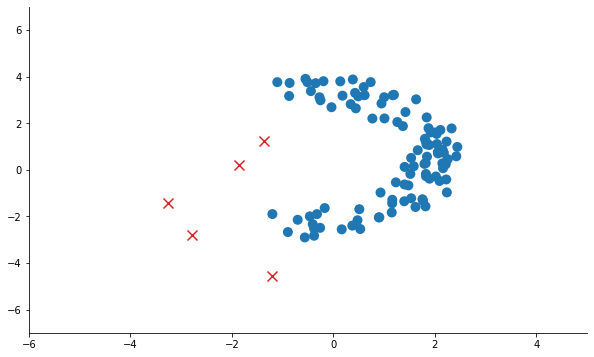

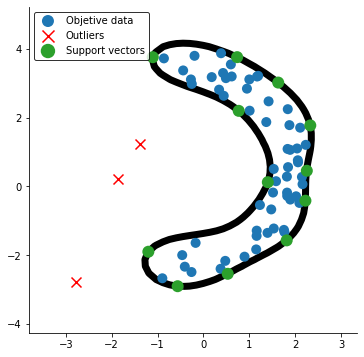



*** Fitting of the SVDD model is completed. ***

running time         = 0.0197 seconds
kernel function      = poly
iterations           = 9
number of samples    = 73
number of features   = 2
number of SVs        = 5
ratio of SVs         = 6.8493 %
accuracy             = 20.5479 %


Calculating the grid scores (0050*0050)...

Calculation of the grid scores is completed. Time cost 0.0426 seconds



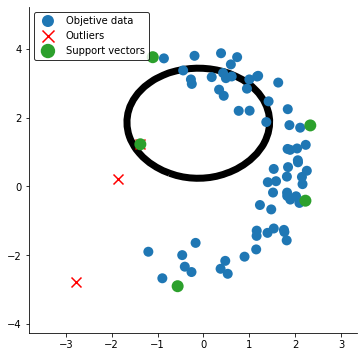



*** Fitting of the SVDD model is completed. ***

running time         = 0.0165 seconds
kernel function      = linear
iterations           = 9
number of samples    = 73
number of features   = 2
number of SVs        = 3
ratio of SVs         = 4.1096 %
accuracy             = 36.9863 %


Calculating the grid scores (0050*0050)...

Calculation of the grid scores is completed. Time cost 0.0255 seconds



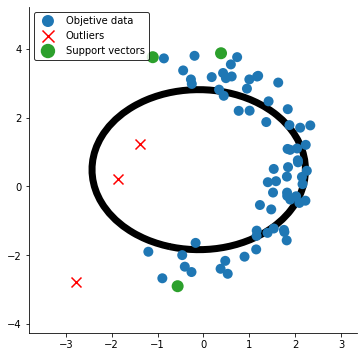

In [ ]:
# -*- coding: utf-8 -*-
"""

An example for SVDD model fitting using different kernels

"""
import sys
sys.path.append("..")
#from src.BaseSVDD import BaseSVDD, BananaDataset

# Banana-shaped dataset generation and partitioning
X, y = BananaDataset.generate(number_p=100, number_n=5, display='on')
X_train, X_test, y_train, y_test = BananaDataset.split(X, y, ratio=0.3)

# kernel list
kernelList = {"1": BaseSVDD(C=0.9, kernel='rbf', gamma=0.3, display='on'),
              "2": BaseSVDD(C=0.9, kernel='poly',degree=2, display='on'),
              "3": BaseSVDD(C=0.9, kernel='linear', display='on')
              }

# 
for i in range(len(kernelList)):
    svdd = kernelList.get(str(i+1))
    svdd.fit(X_train,  y_train)
    svdd.plot_boundary(X_train,  y_train)




